In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM
from keras.layers import Activation, GlobalMaxPool2D, SpatialDropout2D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
#from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


125

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
#channel = np.array([1,3,7,8,21,22,25,26,27,30])
scale = len(np.arange(11, 31))
sampling_rate = 128
window_size = 256
skip =16
#channel_len = len(channel)
classes=2
order = 6
fs = 128      # sample rate, Hz
cutoff = 60  # desired cutoff frequency of the filter, Hz
waveletname = 'db4'
bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 45/(sampling_rate/2)]}

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
skip = 256

for person in range(17,18):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<5] = 0
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    sig = eeg[i][:32, :]
    sig = baseline_remove(sig)
    # Segmenting into 3 seconds (384 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,32,256,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.17
(1200, 32, 256, 1)
(1200,) (540,) (660,)
(1200,) (450,) (750,)


0

In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(17,18):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += window_size 
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.17
(1200, 36, 256)
(1200,) (540,) (660,)
(1200,) (450,) (750,)


0

In [ ]:
import statistics
from scipy import stats
from statistics import variance
 
feature =[]
f_feat = []
for k in range(data.shape[0]):
  for l in range(data.shape[1]):
    feature.append(np.mean(data[k,l,:]))
    feature.append(np.median(data[k,l,:]))
    feature.append(np.var((data[k,l,:])))
    val,counts = np.unique(data[k,l,:], return_counts=True)
    index = np.argmax(counts)
    feature.append(val[index])
    feature.append(np.max(data[k,l,:]))
    feature.append(np.min(data[k,l,:]))

In [ ]:
feature = np.array(feature)
print(feature.shape)
f_feat = np.reshape(feature,[-1,data.shape[1],6])
print(feature)
 
 

(259200,)
[-1.6212761e-03  2.6990426e-01  1.2560635e+02 ... -1.0158933e+02
  6.2379257e+01 -1.0158933e+02]


In [ ]:
f_feat.shape

(1200, 36, 6)

# **Proposed Architecture**

In [ ]:
def individual_1D_CNN(x):
  x = Reshape((x.shape[1],1))(x)
  x1 = Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = 'same', activation='selu')(x)
  x1 = Conv1D(filters = 32, kernel_size = 3, strides = 3, padding = 'same', activation='selu')(x1)
  x1 = Conv1D(filters = 32, kernel_size = 3, strides = 3, padding = 'same', activation='selu')(x1)
  x2 = Conv1D(filters = 32, kernel_size = 3, strides = 3, padding = 'same', activation='selu')(x)
  x2 = Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = 'same', activation='selu')(x2)
  x2 = Conv1D(filters = 32, kernel_size = 3, strides = 3, padding = 'same', activation='selu')(x2)
  x3 = Conv1D(filters = 32, kernel_size = 6, strides = 6, padding = 'same', activation='selu')(x)
  x3 = Conv1D(filters = 32, kernel_size = 3, strides = 3, padding = 'same', activation='selu')(x3)
  x4 = Conv1D(filters = 32, kernel_size = 9, strides = 9, padding = 'same', activation='selu')(x)
  x4 = Conv1D(filters = 32, kernel_size = 2, strides = 2, padding = 'same', activation='selu')(x4)
  x5 = Conv1D(filters = 32, kernel_size = 18, strides = 18, padding = 'same', activation='selu')(x)
  x = Concatenate(axis=2)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv1D(filters = x.shape[2], kernel_size = 2, strides = 2, padding = 'same', activation='selu')(x)
  x = Dropout(0.1)(x)
  x = Flatten()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Reshape((x.shape[1],1))(x)
  return x
def simple_1D_CNN(x): 
  x1 = individual_1D_CNN(x[:,:,0])
  x2 = individual_1D_CNN(x[:,:,1])
  x3 = individual_1D_CNN(x[:,:,2])
  x4 = individual_1D_CNN(x[:,:,3])
  x5 = individual_1D_CNN(x[:,:,4])
  x6 = individual_1D_CNN(x[:,:,5])
  x = Concatenate(axis=2)([x1, x2, x3, x4, x5, x6])
  x = Conv1D(filters = 32, kernel_size = 4, strides = 4, padding = 'same', activation='selu')(x)
  x = Flatten()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (f_feat.shape[1], f_feat.shape[2]) 
  a = Input(input_shape) 
  out = simple_1D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-05) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 36, 6)]      0           []                               
                                                                                                  
 tf.__operators__.getitem_56 (S  (None, 36)          0           ['input_16[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_57 (S  (None, 36)          0           ['input_16[0][0]']               
 licingOpLambda)                                                                                  
                                                                                           

In [ ]:
batch_size = 64
epochs = 200
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

11948

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(f_feat,valence, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(960, 36, 6) (240, 36, 6) (960, 2) (240, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}

foldNum=0
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model = get_model()
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  val_res['f1_score'].append(f1_score(y_test.argmax(1), pred.argmax(1), average='macro'))
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/200
14/14 [==============================] - 7s 110ms/step - loss: 0.8250 - accuracy: 0.4525 - val_loss: 0.7511 - val_accuracy: 0.4271
Epoch 2/200
14/14 [==============================] - 0s 21ms/step - loss: 0.7296 - accuracy: 0.4931 - val_loss: 0.6886 - val_accuracy: 0.5312
Epoch 3/200
14/14 [==============================] - 0s 22ms/step - loss: 0.7305 - accuracy: 0.5000 - val_loss: 0.6840 - val_accuracy: 0.5938
Epoch 4/200
14/14 [==============================] - 0s 21ms/step - loss: 0.7061 - accuracy: 0.5417 - val_loss: 0.6892 - val_accuracy: 0.5625
Epoch 5/200
14/14 [==============================] - 0s 21ms/step - loss: 0.7189 - accuracy: 0.5012 - val_loss: 0.6910 - val_accuracy: 0.5625
Epoch 6/200
14/14 [==============================] - 0s 23ms/step - loss: 0.7038 - accuracy: 0.5336 - val_loss: 0.6928 - val_accuracy: 0.5729
Epoch 7/200
14/14 [==============================] - 0s 21ms/step - loss: 0.7025 - accuracy: 0.5278 - val_loss: 0.6955 - val_acc

In [ ]:
print("Accuracy : ")
accr=[]
Fscr=[]
for i in val_res['accuracy']:
  print(round(i[1]*100, 2)) # Rounding off to two decimal places
  accr.append(round(i[1]*100, 2))
print(np.array(accr).mean()) 
print("......................")
print("F1 Score : ")
for i in val_res['f1_score']:
  print(round(i*100, 2)) # Rounding off to two decimal places
  Fscr.append(round(i*100, 2))
print(np.array(Fscr).mean()) 
print("......................")
print("Confusion Matrix")
for i in val_res['confusion_matrix']:
  print(i)

Accuracy : 
56.67
55.0
56.25
57.08
52.5
58.75
58.33
52.08
53.33
56.25
55.624
......................
F1 Score : 
56.07
50.27
55.41
52.97
52.38
54.54
56.6
50.64
49.76
51.23
52.987
......................
Confusion Matrix
[[54 54]
 [50 82]]
[[ 29  79]
 [ 29 103]]
[[51 57]
 [48 84]]
[[ 33  75]
 [ 28 104]]
[[57 51]
 [63 69]]
[[ 34  74]
 [ 25 107]]
[[46 62]
 [38 94]]
[[42 66]
 [49 83]]
[[32 76]
 [36 96]]
[[ 29  79]
 [ 26 106]]


Accuracy  : 0.5562499940395356
F1_Score  : 0.5298715100829045


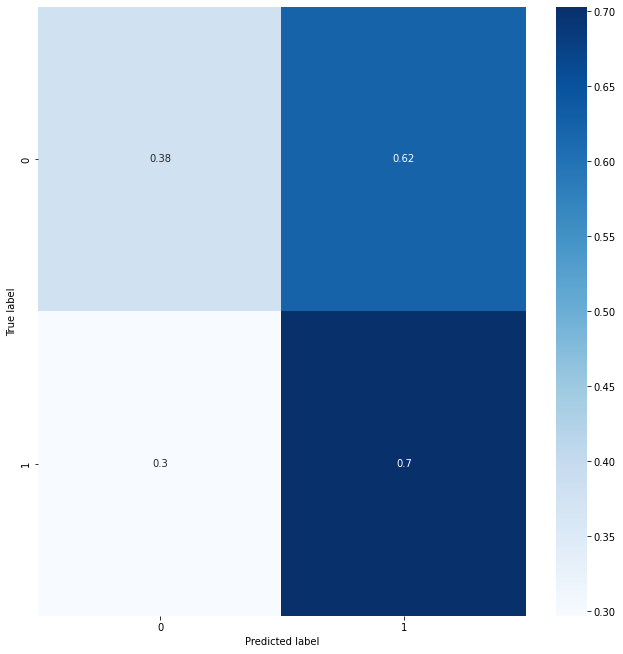

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}

foldNum=0
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model = get_model()
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  val_res['f1_score'].append(f1_score(y_test.argmax(1), pred.argmax(1), average='macro'))
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

In [ ]:
print("Accuracy : ")
accr=[]
Fscr=[]
for i in val_res['accuracy']:
  print(round(i[1]*100, 2)) # Rounding off to two decimal places
  accr.append(round(i[1]*100, 2))
print(np.array(accr).mean()) 
print("......................")
print("F1 Score : ")
for i in val_res['f1_score']:
  print(round(i*100, 2)) # Rounding off to two decimal places
  Fscr.append(round(i*100, 2))
print(np.array(Fscr).mean()) 
print("......................")
print("Confusion Matrix")
for i in val_res['confusion_matrix']:
  print(i)

# **Dominance**

In [ ]:
#dominance
X_train, x_test, Y_train, y_test = train_test_split(data,dominance, test_size=0.2, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(7456, 200, 256, 1) (1864, 200, 256, 1) (7456, 3) (1864, 3)


In [ ]:
foldNum=0
model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val
  gc.collect()

Results for fold 1
Epoch 1/50
53/53 [==============================] - 4s 53ms/step - loss: 0.9482 - accuracy: 0.5729 - val_loss: 0.8301 - val_accuracy: 0.6542
Epoch 2/50
53/53 [==============================] - 2s 41ms/step - loss: 0.8373 - accuracy: 0.6235 - val_loss: 0.8019 - val_accuracy: 0.6542
Epoch 3/50
53/53 [==============================] - 2s 41ms/step - loss: 0.8281 - accuracy: 0.6491 - val_loss: 0.7896 - val_accuracy: 0.6542
Epoch 4/50
53/53 [==============================] - 2s 42ms/step - loss: 0.7968 - accuracy: 0.6566 - val_loss: 0.7841 - val_accuracy: 0.6542
Epoch 5/50
53/53 [==============================] - 2s 41ms/step - loss: 0.8122 - accuracy: 0.6519 - val_loss: 0.7851 - val_accuracy: 0.6542
Epoch 6/50
53/53 [==============================] - 2s 41ms/step - loss: 0.8098 - accuracy: 0.6480 - val_loss: 0.7850 - val_accuracy: 0.6542
Epoch 7/50
53/53 [==============================] - 2s 42ms/step - loss: 0.7966 - accuracy: 0.6586 - val_loss: 0.7839 - val_accuracy: 0

59/59 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 0.9984
Accuracy  : 0.9983905553817749
F1_Score  : 0.9987261141904896


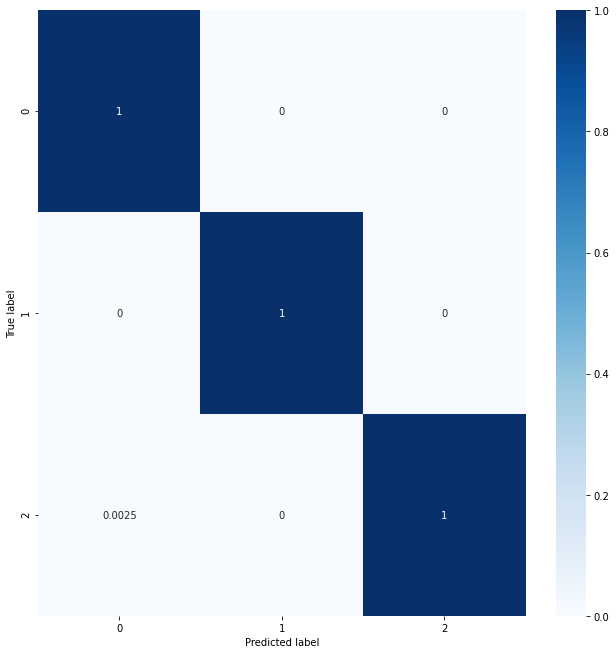

In [ ]:
acrc = model.evaluate(x_test, y_test)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
c_matrix = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
c_matrix = c_matrix/np.sum(c_matrix, axis=1).reshape(3,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()